In [1]:
TRAIN_IMAGES_DIR = "../data/raw/DOTA/training/images/"
TRAIN_LABELS_DIR = "../data/raw/DOTA/training/labelTxt/"

In [124]:
import numpy as np
import pandas as pd
import os

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

import sys
sys.path.insert(0, "../")

import lib.pandas_utilities as pdu
from lib.visualize import PlotOp

# Load and preprocess

### Read all labels for objects in images

In [3]:
all_labels_df = pd.DataFrame()

for file in sorted(os.listdir(TRAIN_LABELS_DIR)):
    
    file_path = TRAIN_LABELS_DIR + file
    
    img_id = file[1:5]
    
    with open(file_path) as f:
        img_source = f.readline().split(':')[-1][:-1] # clip last element which is \n
        gsd = f.readline().split(':')[-1][:-1]
    
    label_df = pd.read_csv(
        file_path, 
        sep=" ", skiprows=2, header=None,
        names = ["x1","y1","x2","y2","x3","y3","x4","y4","category","difficulty"]
    )
    
    label_df["img_source"] = img_source
    label_df["gsd"] = gsd
    label_df["img_id"] = img_id
    
    SELECT = ["img_id","img_source","gsd","category","difficulty"]
    label_df = label_df[SELECT]
    
    all_labels_df = pd.concat([all_labels_df, label_df])

### Convert image ids and ground sample distances (gsd) to numeric

In [11]:
all_labels_df["img_id"] = pd.to_numeric(all_labels_df["img_id"], errors="coerce")
all_labels_df["gsd"] = pd.to_numeric(all_labels_df["gsd"], errors="coerce")

### all_img_df keeps one row per image

In [13]:
all_img_df = all_labels_df.drop_duplicates("img_id")

# Report

## Number of training images

In [14]:
len(all_img_df)

1409

## Summary of image features

In [15]:
pdu.summary(all_img_df)

,column,filled,n_unique,uniques/filled,dtype,mean,std
0,img_id,100%,1409,100%,int64,1407.97,818.07
1,img_source,100%,3,0%,object,N/A,N/A
2,gsd,100%,1198,85%,float64,0.39,0.37
3,category,100%,15,1%,object,N/A,N/A
4,difficulty,100%,2,0%,float64,0.10,0.30


## Count of images by source

In [16]:
all_img_df.img_source.value_counts()

GoogleEarth    1208
JL              116
GF               85
Name: img_source, dtype: int64

### Distribution of ground sample distances (gsd) of images

/Users/baris.ozmen/miniconda3/envs/insight/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


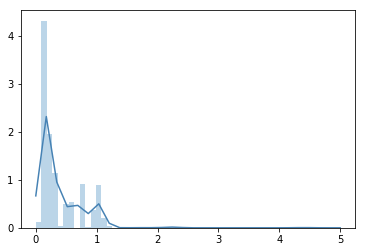

In [115]:
gsd_values = all_img_df["gsd"].dropna().values

h = plt.hist(gsd_values, bins=50, normed=1, alpha=0.3)

density = gaussian_kde( gsd_values )

xs = np.linspace(0,5,30)
plt.plot(xs, density(xs), color="steelblue")

### Take a look to all_labels_df

In [53]:
all_labels_df.head()

,img_id,img_source,gsd,category,difficulty
0,0,GoogleEarth,0.146344,plane,0.0
1,0,GoogleEarth,0.146344,large-vehicle,0.0
2,0,GoogleEarth,0.146344,large-vehicle,0.0
3,0,GoogleEarth,0.146344,large-vehicle,0.0
4,0,GoogleEarth,0.146344,small-vehicle,0.0


### Frequency of each object type across images

Frequency of objects vary between 325 (ground-track-field) and 28,068 (ship)

Text(0.5, 1.0, 'Frequency of each object type across aerial images')

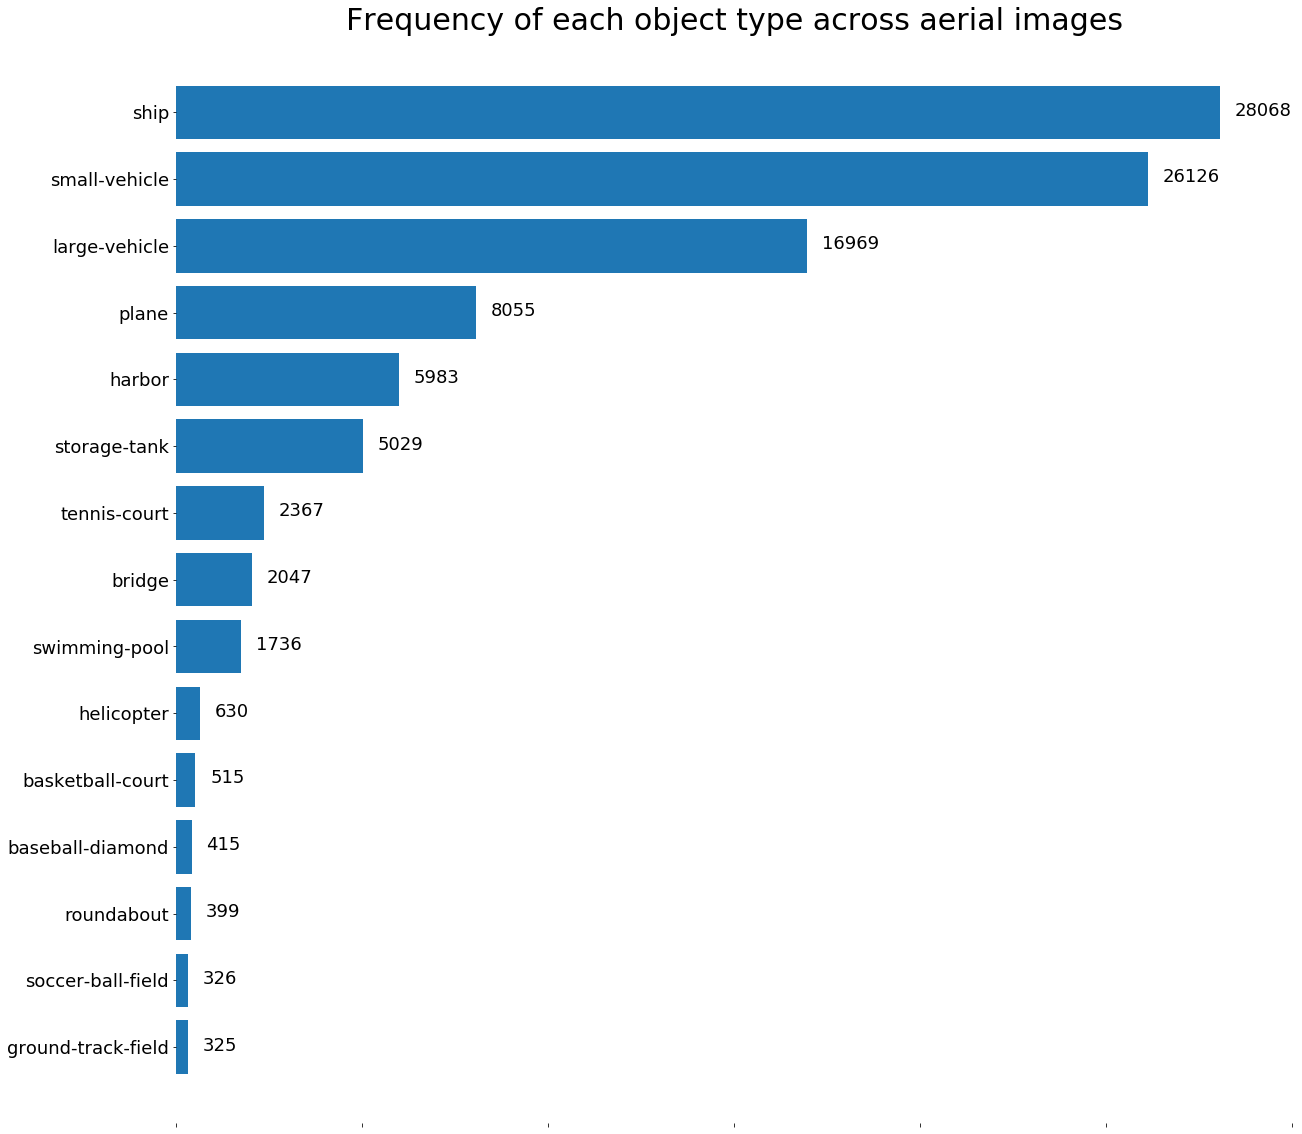

In [106]:
categs = all_labels_df["category"].value_counts(ascending=True)

plt.figure(figsize=(20,20))
plt.barh(categs.index, categs.values)

ax = plt.gca()
for i, val in enumerate(categs.values):
    ax.text(val + 400, i-0.05, str(val), fontsize=18)

ax.set_xlim(0,30000)
ax.tick_params(labelleft=True, labelbottom=False)



for spine in ax.spines.values():
    spine.set_visible(False)
    
ax.tick_params(axis='both', which='major', labelsize=18)
    
plt.title('Frequency of each object type across aerial images', fontsize=30)

### Number of objects per image

Number of objects follows an exponential decay

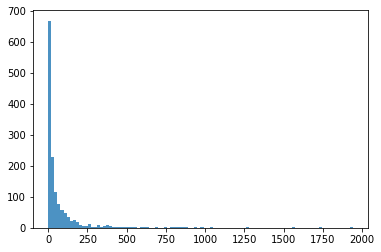

In [120]:
n_objects = all_labels_df.groupby("img_id").count()["category"].values

h = plt.hist(n_objects, bins=100, alpha=0.8)

### Images by number of each object

In [134]:
df = all_labels_df.drop(columns=["gsd", "difficulty"]).copy()

for categ in all_labels_df.category.unique():
    df[categ] = df["category"]==categ
    
label_counts_df = df.groupby("img_id").sum()

label_counts_df.head()

,plane,large-vehicle,small-vehicle,ship,harbor,ground-track-field,soccer-ball-field,tennis-court,baseball-diamond,swimming-pool,roundabout,basketball-court,storage-tank,bridge,helicopter
img_id,,,,,,,,,,,,,,,
0,21.0,27.0,59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,17.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,257.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,99.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,36.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Co-occurrences and mutual exclusivity of object types across images

Correlation results are not surprising. High correlations are between ground-track-field/soccer-ball-field and helicopter/plane, becasue these tuples are tend to be in the same images. Again uninterestingly, planes are tennis-courts are negatively correlated, since it is unlikely to have a tennis court near an airport.

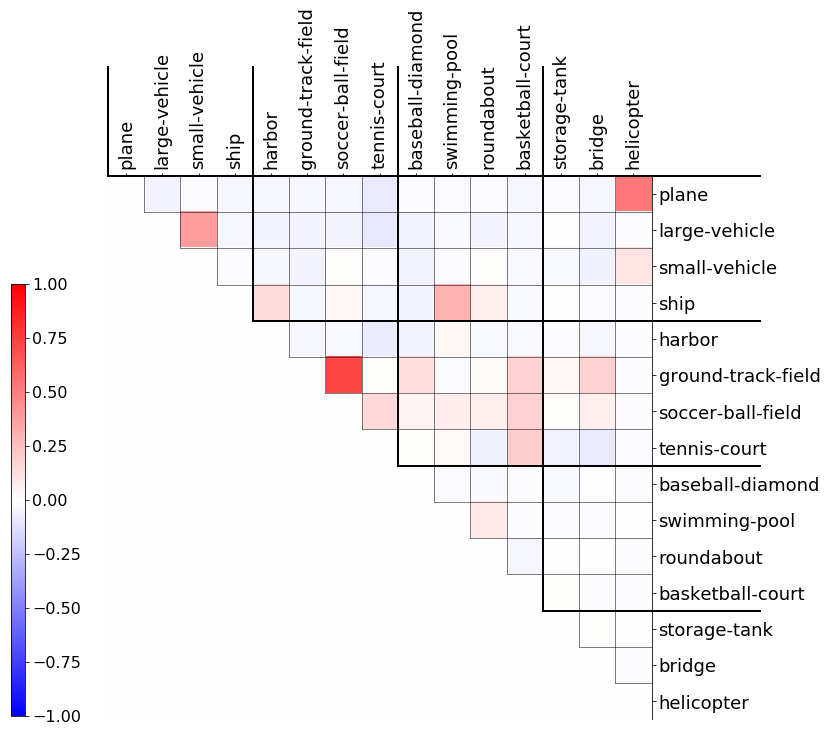

plot_heatmap_of_uppertriangle() call counter:  8
plot_heatmap_of_uppertriangle()'s runtime:  0.4519 sec.


In [144]:
PlotOp.plot_heatmap_of_uppertriangle(
    label_counts_df.corr().values,
    label_counts_df.columns,
    label_counts_df.columns,
    sg_length=-3,
    figsize=(10,10)
)

# Show image samples

In [147]:
import cv2

# Functions to visualize bounding boxes and class labels on an image. 
# Based on https://github.com/facebookresearch/Detectron/blob/master/detectron/utils/vis.py

BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)


def visualize_bbox(img, bbox, class_id, class_idx_to_name, color=BOX_COLOR, thickness=2):
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = class_idx_to_name[class_id]
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img


def visualize(annotations, category_id_to_name):
    img = annotations['image'].copy()
    for idx, bbox in enumerate(annotations['bboxes']):
        img = visualize_bbox(img, bbox, annotations['category_id'][idx], category_id_to_name)
    plt.figure(figsize=(12, 12))
    plt.imshow(img)

In [ ]:
from PIL import Image

annotations = {
    "image" = Image.open(TRAIN_IMAGES_DIR+"P0000.png")
    "bboxes" = []
}

In [ ]:
TRAIN_LABELS_DIR+"P0000.png"